## <font color='navy'> Examen 4. Laboratorio de Aprendizaje Estadístico.
    
### <font color='navy'> PCA, KMeans y Learners

Luis Fernando Márquez Bañuelos | 744489

In [1]:
import shap
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier, LGBMRegressor, early_stopping, log_evaluation, plot_importance

pd.set_option('display.float_format', '{:,.4f}'.format)

## <font color='navy'> Importación de datos

In [2]:
data = pd.read_csv('hr_role.csv')
data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,is_satisfied
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,80,0,8,0,1,6,4,0,5,True
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,80,1,10,3,3,10,7,1,7,False
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,80,0,7,3,3,0,0,0,0,False
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,...,80,0,8,3,3,8,7,3,0,False
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,...,80,1,6,3,3,2,2,2,2,False


## <font color='navy'> Funciones

In [3]:
def histograma(probabilidades: np.ndarray, y_test: str):
    juntar = pd.DataFrame({
    'real': y_test,
    'probabilidades': probabilidades
    })
    plt.figure(figsize=(10, 5))
    plt.hist(juntar[juntar.real == 1]['probabilidades'], density=True, alpha=0.5, label = '1', color= 'skyblue')
    plt.hist(juntar[juntar.real == 0]['probabilidades'], density=True, alpha=0.5, label = '0', color = 'indianred')
    plt.title(f'Histograma de probabilidades de')
    plt.xlabel('Probabilidad')
    plt.ylabel('Densidad')
    plt.legend()
    plt.show()

## <font color='navy'> Preparación de Datos

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EnvironmentSatisfaction   1470 non-null   int64 
 9   Gender                    1470 non-null   object
 10  HourlyRate                1470 non-null   int64 
 11  JobInvolvement            1470 non-null   int64 
 12  JobLevel                  1470 non-null   int64 
 13  JobRole                   1470 non-null   object
 14  MaritalStatus           

Ninguna de las variables del dataset tiene datos nulos, por lo que no será necesario hacer limpieza de datos. Sin embargo se pueden poner multiples variables en un tipo más adecuado.

In [5]:
categorical_cols = [
    'BusinessTravel', 'Department', 'EducationField',
    'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime'
]

int8_cols = ['Age', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction',
             'JobInvolvement', 'JobLevel', 'RelationshipSatisfaction',
             'StockOptionLevel', 'TrainingTimesLastYear', 'WorkLifeBalance']

int32_cols = [
    'DailyRate', 'HourlyRate', 'MonthlyIncome', 'MonthlyRate',
    'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating',
    'TotalWorkingYears', 'YearsAtCompany', 'YearsInCurrentRole',
    'YearsSinceLastPromotion', 'YearsWithCurrManager'
]

data[int8_cols] = data[int8_cols].astype('int8')
data[int32_cols] = data[int32_cols].apply(pd.to_numeric, downcast='integer')
data[categorical_cols] = data[categorical_cols].astype('category')

In [6]:
data['Attrition'] = data['Attrition'].map({'Yes': True, 'No': False})
target = 'Attrition'
data = pd.get_dummies(data)

In [7]:
X = data.copy()
X = X.drop(columns=[target])
y = data[target]

## <font color='navy'> 1- PCA

In [8]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA())
])
pipeline.fit(X)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA())])

In [9]:
objeto_pca = pipeline.named_steps['pca']
X_pca = pipeline.transform(X)
X_componentes = pd.DataFrame(X_pca, columns=[f'PCA {i+1}' for i in range(X_pca.shape[1])])
X_componentes.head()

,PCA 1,PCA 2,PCA 3,PCA 4,PCA 5,PCA 6,PCA 7,PCA 8,PCA 9,PCA 10,...,PCA 44,PCA 45,PCA 46,PCA 47,PCA 48,PCA 49,PCA 50,PCA 51,PCA 52,PCA 53
0,-0.0303,-2.3304,-1.1614,-3.2175,-0.1139,0.2535,-1.0405,0.3092,-0.4480,2.1116,...,0.0149,0.0000,-0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,-0.0000
1,0.0497,1.5437,-0.2139,1.6625,0.7196,-2.2080,1.0955,-1.0808,2.4273,1.2482,...,-0.1029,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000
2,-2.9220,0.9963,-0.2068,-1.5847,-0.0958,0.0983,-2.7826,0.8389,0.4165,-0.6430,...,-0.0992,-0.0000,-0.0000,-0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000,-0.0000
3,-1.1874,1.0543,-0.6928,-2.3067,-0.2285,-2.3924,1.0586,-0.0715,-1.8439,1.8181,...,0.0460,-0.0000,-0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,-0.0000,-0.0000
4,-2.1227,1.1964,0.5328,1.2881,-0.6940,1.6858,-0.5015,0.2727,-0.6313,-1.7150,...,0.1490,-0.0000,0.0000,-0.0000,-0.0000,-0.0000,0.0000,0.0000,-0.0000,-0.0000


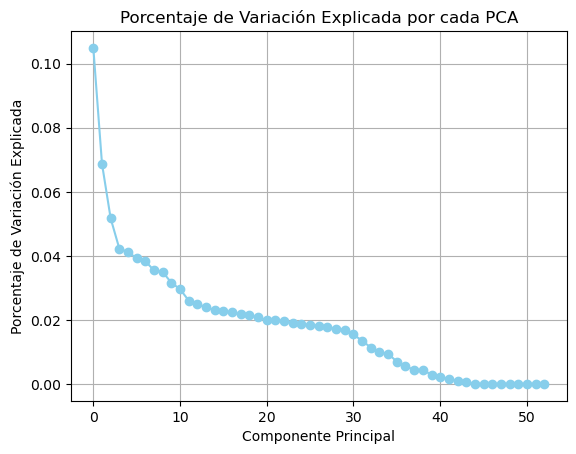

In [10]:
plt.plot(objeto_pca.explained_variance_ratio_, marker='o', color = 'skyblue')
plt.title('Porcentaje de Variación Explicada por cada PCA')
plt.xlabel('Componente Principal')
plt.ylabel('Porcentaje de Variación Explicada')
plt.grid()
plt.show()

## <font color='navy'> 2- KMeans

### <font color='cornflowerblue'> Gráfica del codo

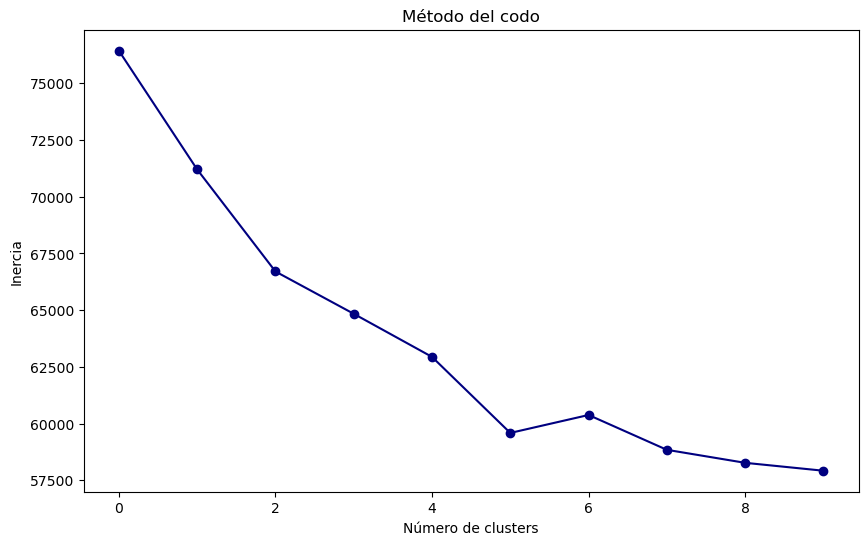

In [11]:
data.dropna(axis=0, inplace=True)

# Guarda la varianza del cluster o "inertia"
inertias = []

# ¿Cuantos clusters probar?
K_range = range(1, 11)
for i in K_range:
    pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=i, random_state=42))
    ])
    pipeline.fit(data)
    inertias.append(pipeline.named_steps['kmeans'].inertia_)

plt.figure(figsize=(10, 6))
plt.plot(inertias, marker = 'o', c = 'navy')
plt.title('Método del codo')
plt.xlabel('Número de clusters')
plt.ylabel('Inercia')
plt.show()

In [12]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=3, random_state=42))
])
pipeline.fit(data)

Pipeline(steps=[('scaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=3, random_state=42))])

In [13]:
data['cluster'] = pipeline.predict(data)

### <font color='cornflowerblue'> Análisis de clusters

In [14]:
pct = data.groupby('cluster').mean()
pct

,Age,Attrition,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Over18_Y,OverTime_No,OverTime_Yes
cluster,,,,,,,,,,,,,,,,,,,,,
0,34.9138,0.1663,801.5567,9.1650,2.8534,2.7500,66.1897,2.7451,1.4975,"4,144.3276",...,0.0000,0.3584,0.0000,0.0000,0.2278,0.4446,0.3276,1.0000,0.7266,0.2734
1,35.1504,0.2206,800.0526,9.3885,2.9123,2.6792,65.1930,2.6967,2.0351,"5,911.9699",...,0.0000,0.0000,0.7870,0.2080,0.1955,0.4536,0.3509,1.0000,0.7093,0.2907
2,45.9575,0.0541,809.1467,8.9768,3.1004,2.6988,66.0309,2.7336,3.8842,"14,807.8726",...,0.3089,0.0039,0.0463,0.0000,0.2471,0.5058,0.2471,1.0000,0.6988,0.3012


## <font color='navy'> 3- Hacer modelos

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### <font color='cornflowerblue'> LightGBM variables

In [16]:
model = LGBMClassifier(
    n_estimators=200,
    num_leaves=10,
    learning_rate=0.1,
    max_depth=6,
    lambda_l2=0.1,
    subsample=0.8,
    feature_fraction=0.8,
    verbosity=-1,
    random_state=42,
    early_stopping_rounds=20,
    eval_metric='auc',
    n_jobs=-1
)


model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
          eval_metric='auc',
          callbacks=[early_stopping(20),
                     log_evaluation(100)])

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[73]	training's auc: 0.991691	training's binary_logloss: 0.152619	valid_1's auc: 0.781197	valid_1's binary_logloss: 0.319638


LGBMClassifier(early_stopping_rounds=20, eval_metric='auc',
               feature_fraction=0.8, lambda_l2=0.1, max_depth=6,
               n_estimators=200, n_jobs=-1, num_leaves=10, random_state=42,
               subsample=0.8, verbosity=-1)

In [17]:
probabilidades = model.predict_proba(X_test)[:, 1]
lgbm_auc = roc_auc_score(y_test, probabilidades)
print(f'AUC: {lgbm_auc:.4f}')

AUC: 0.7812


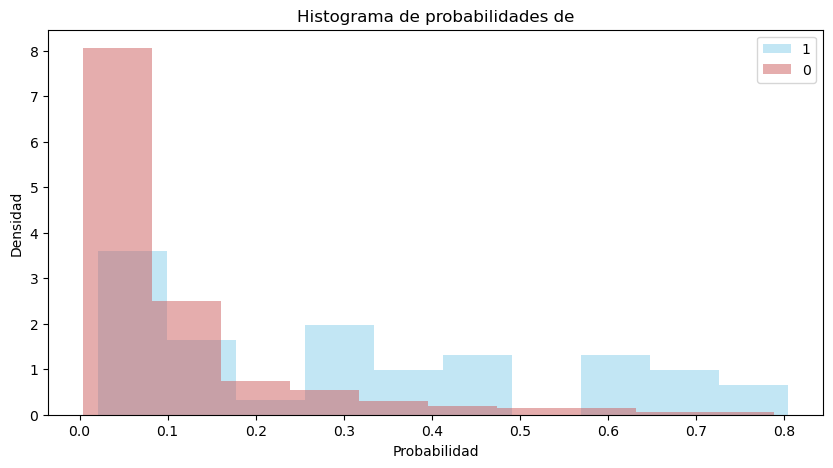

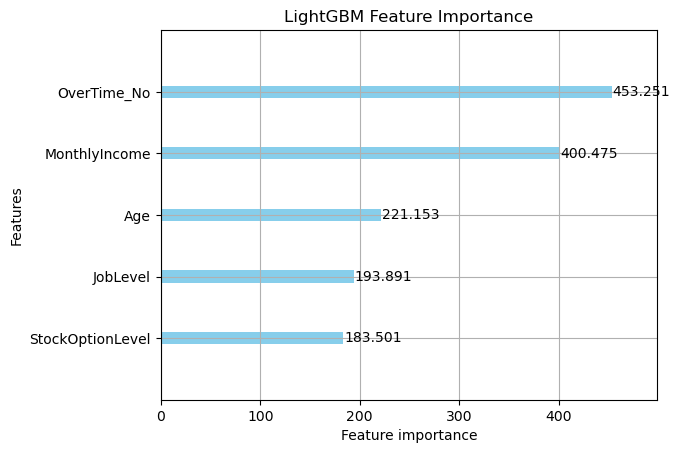

In [18]:
histograma(probabilidades, y_test)
plot_importance(model, max_num_features=5, importance_type='gain', title='LightGBM Feature Importance', color='skyblue')
plt.show()

### <font color='cornflowerblue'> Shap values

In [19]:
# Sample
X_shap = X_test.sample(290, random_state=42)

# Inicializa los shaps explainer SHAP, shap.TreeExplainer
explainer = shap.TreeExplainer(model)

# explainer.shap_values
shap_values = explainer.shap_values(X_shap)

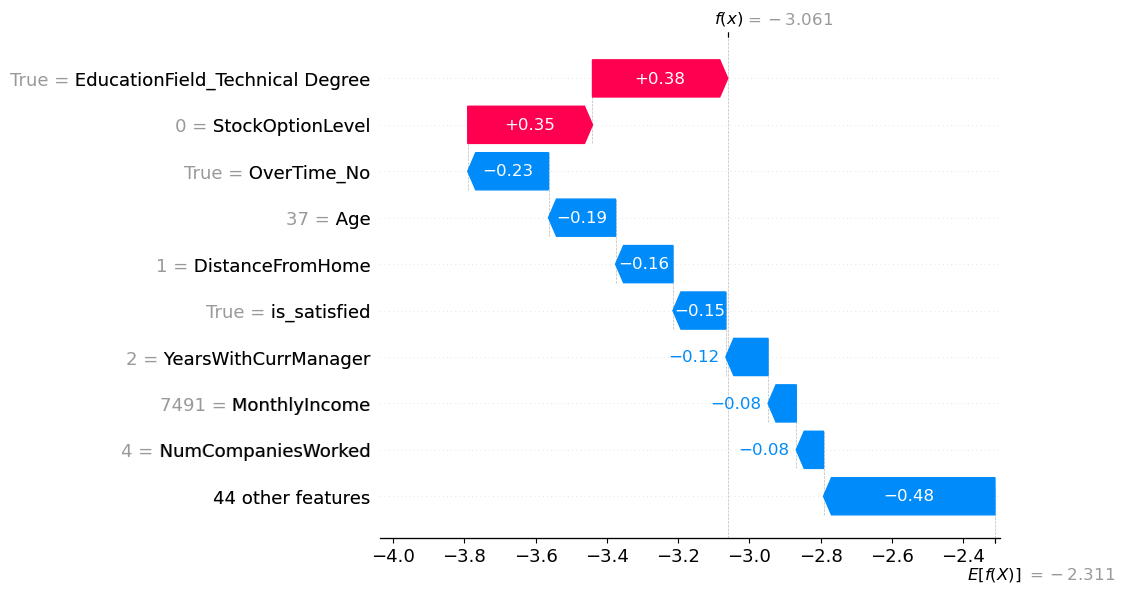

In [20]:
# Incicializa los shaps  initjs()
shap.initjs()

# Para visualizar shap individual con waterfall plot
n_dato = 0

# Visualiza el shap individual
shap.waterfall_plot(shap.Explanation(
        values=shap_values[n_dato],
        base_values=explainer.expected_value,
        data=X_shap.iloc[n_dato],
        feature_names=X_shap.columns
))

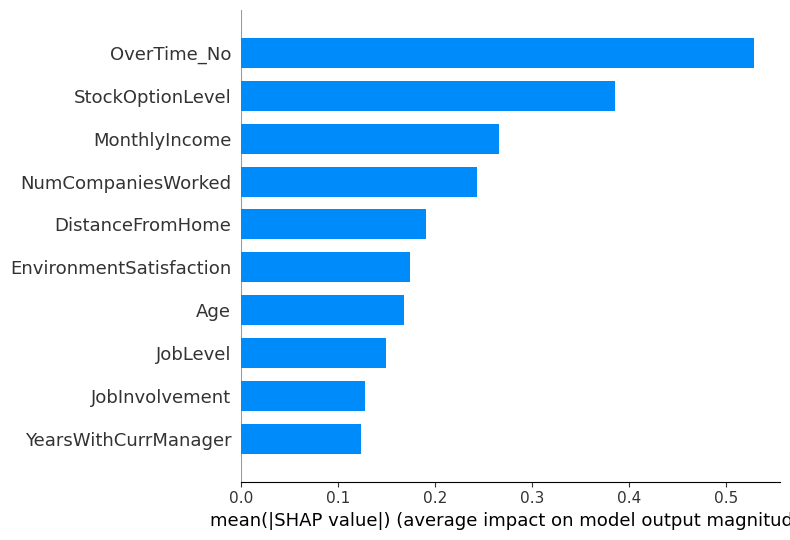

In [21]:
shap.summary_plot(shap_values, X_shap, plot_type="bar", max_display=10)

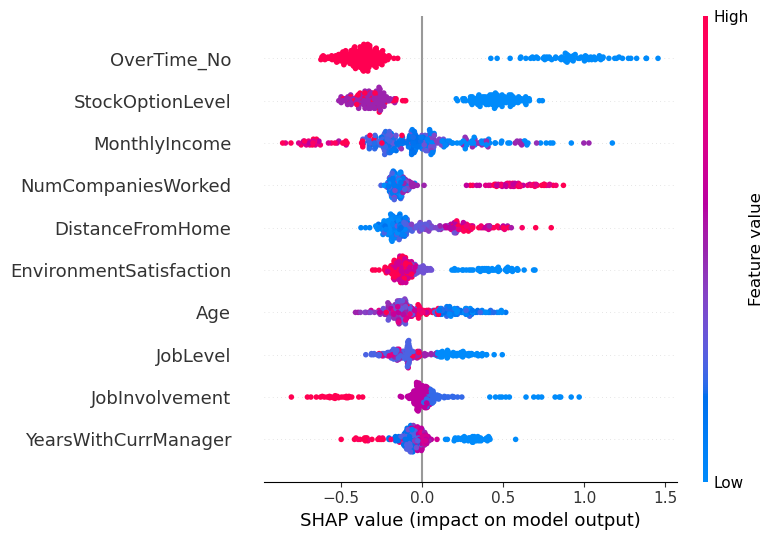

In [22]:
shap.summary_plot(shap_values, X_shap, plot_type="dot", max_display=10)

### <font color='cornflowerblue'> LightGBM PCA

In [23]:
XC_train = X_componentes.loc[X_train.index]
XC_test = X_componentes.loc[X_test.index]

In [24]:
model = LGBMClassifier(
    n_estimators=200,
    num_leaves=10,
    learning_rate=0.1,
    max_depth=6,
    lambda_l2=0.1,
    subsample=0.8,
    feature_fraction=0.8,
    verbosity=-1,
    random_state=42,
    early_stopping_rounds=20,
    eval_metric='auc',
    n_jobs=-1
)


model.fit(XC_train, y_train, eval_set=[(XC_train, y_train), (XC_test, y_test)],
          eval_metric='auc',
          callbacks=[early_stopping(20),
                     log_evaluation(100)])

Training until validation scores don't improve for 20 rounds


LGBMClassifier(early_stopping_rounds=20, eval_metric='auc',
               feature_fraction=0.8, lambda_l2=0.1, max_depth=6,
               n_estimators=200, n_jobs=-1, num_leaves=10, random_state=42,
               subsample=0.8, verbosity=-1)

In [25]:
probabilidades = model.predict_proba(XC_test)[:, 1]
lgbm_auc = roc_auc_score(y_test, probabilidades)
print(f'AUC: {lgbm_auc:.4f}')

AUC: 0.7624


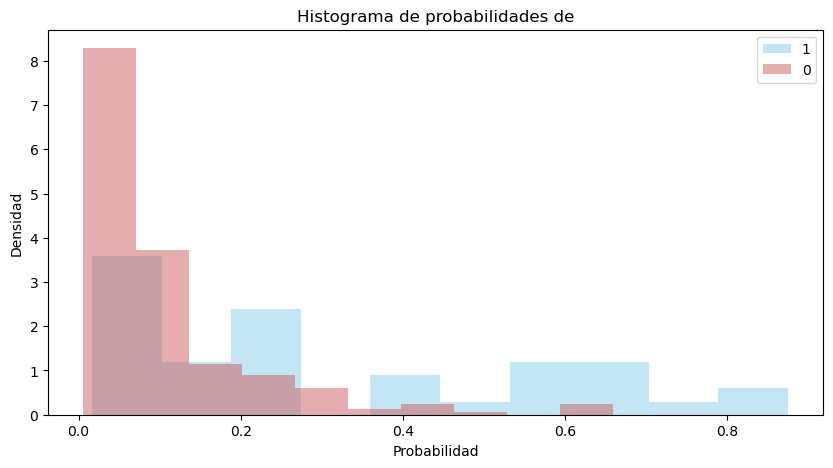

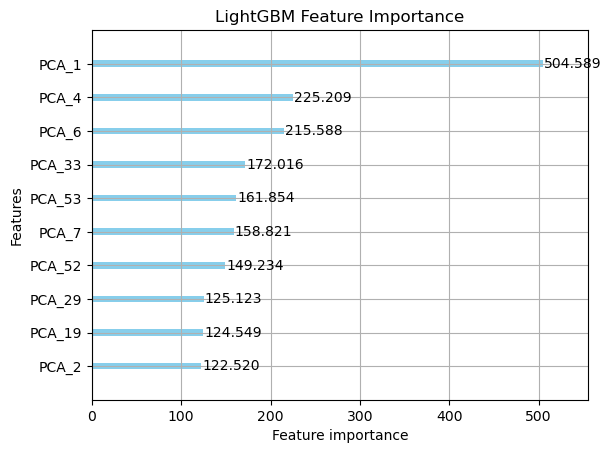

In [26]:
histograma(probabilidades, y_test)
plot_importance(model, max_num_features=10, importance_type='gain', title='LightGBM Feature Importance', color='skyblue')
plt.show()

Con la gráfica de plot importance se puede ver que las componentes más immportantes son la 1, 4, 6 y 33. A partir de estas la importancia disminuye considerablemente, además hace sentido que hayan sido importantes para el modelo puesto que están entre las primeras seis PCA que más reducen la varianza. Como punto interesante es que la PCA 33 haya sido de alta importancia considerando que su reducción de varianza es muy baja.

### <font color='cornflowerblue'> LightGBM PCA importantes

In [27]:
x_pca_train = XC_train[['PCA 1', 'PCA 4', 'PCA 6', 'PCA 33']]
x_pca_test = XC_test[['PCA 1', 'PCA 4', 'PCA 6', 'PCA 33']]

In [28]:
model = LGBMClassifier(
    n_estimators=200,
    num_leaves=10,
    learning_rate=0.1,
    max_depth=6,
    lambda_l2=0.1,
    subsample=0.8,
    feature_fraction=0.8,
    verbosity=-1,
    random_state=42,
    early_stopping_rounds=20,
    eval_metric='auc',
    n_jobs=-1
)


model.fit(x_pca_train, y_train, eval_set=[(x_pca_train, y_train), (x_pca_test, y_test)],
          eval_metric='auc',
          callbacks=[early_stopping(20),
                     log_evaluation(100)])

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[11]	training's auc: 0.855252	training's binary_logloss: 0.354294	valid_1's auc: 0.667622	valid_1's binary_logloss: 0.372472


LGBMClassifier(early_stopping_rounds=20, eval_metric='auc',
               feature_fraction=0.8, lambda_l2=0.1, max_depth=6,
               n_estimators=200, n_jobs=-1, num_leaves=10, random_state=42,
               subsample=0.8, verbosity=-1)

In [29]:
probabilidades = model.predict_proba(x_pca_test)[:, 1]
lgbm_auc = roc_auc_score(y_test, probabilidades)
print(f'AUC: {lgbm_auc:.4f}')

AUC: 0.6676


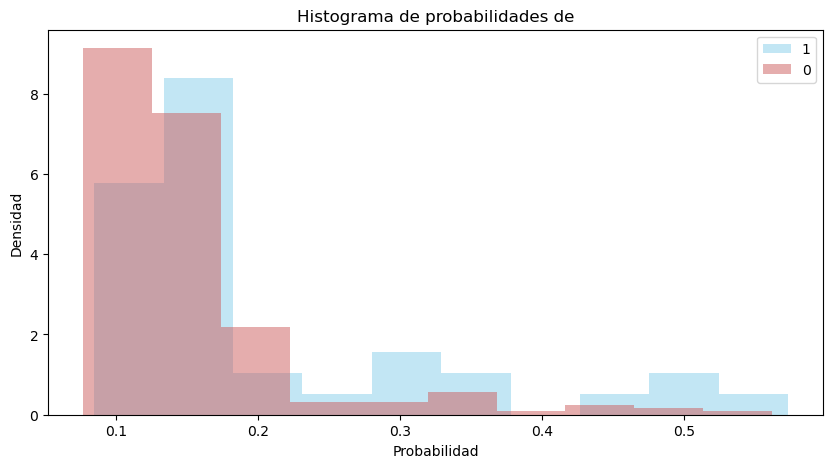

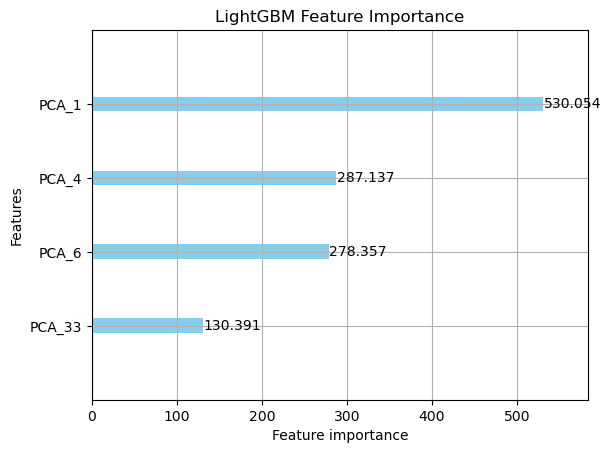

In [30]:
histograma(probabilidades, y_test)
plot_importance(model, max_num_features=10, importance_type='gain', title='LightGBM Feature Importance', color='skyblue')
plt.show()

## <font color='navy'> 4- Dataset Diabetes

## <font color='navy'> Importación de datos

In [31]:
data = pd.read_csv('diabetes.csv')
data.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,diabetes
0,Female,80.0000,0,1,never,25.1900,0
1,Female,54.0000,0,0,No Info,27.3200,0
2,Male,28.0000,0,0,never,27.3200,0
3,Female,36.0000,0,0,current,23.4500,0
4,Male,76.0000,1,1,current,20.1400,0


## <font color='navy'> Preparación de datos

In [32]:
data['smoking_history'] = data['smoking_history'].map({'No Info': 0, 'never': 0, 'former': 1, 
                                                       'current': 1, 'not current': 1, 'ever':1})
data = pd.get_dummies(data, columns=['gender'])
target = 'diabetes'
data.head()

,age,hypertension,heart_disease,smoking_history,bmi,diabetes,gender_Female,gender_Male,gender_Other
0,80.0000,0,1,0,25.1900,0,True,False,False
1,54.0000,0,0,0,27.3200,0,True,False,False
2,28.0000,0,0,0,27.3200,0,False,True,False
3,36.0000,0,0,1,23.4500,0,True,False,False
4,76.0000,1,1,1,20.1400,0,False,True,False


In [33]:
X = data.copy()
X = X.drop(columns=[target])
y = data[target]

### <font color='cornflowerblue'> S learner

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
model = LGBMClassifier(
    n_estimators=200,
    num_leaves=10,
    learning_rate=0.1,
    max_depth=6,
    lambda_l2=0.1,
    subsample=0.8,
    feature_fraction=0.8,
    verbosity=-1,
    random_state=42,
    early_stopping_rounds=20,
    eval_metric='auc',
    n_jobs=-1
)


model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
          eval_metric='auc',
          callbacks=[early_stopping(50),
                     log_evaluation(100)])

Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.839711	training's binary_logloss: 0.225697	valid_1's auc: 0.835882	valid_1's binary_logloss: 0.228713


LGBMClassifier(early_stopping_rounds=20, eval_metric='auc',
               feature_fraction=0.8, lambda_l2=0.1, max_depth=6,
               n_estimators=200, n_jobs=-1, num_leaves=10, random_state=42,
               subsample=0.8, verbosity=-1)

In [36]:
probabilidades = model.predict_proba(X_test)[:, 1]
lgbm_auc = roc_auc_score(y_test, probabilidades)
print(f'AUC: {lgbm_auc:.4f}')

AUC: 0.8359


In [37]:
# Pon 0 a todas las promos
X_test_counter_0 = X_test.copy()
X_test_counter_0['smoking_history'] = 0
# Pon 1 toda las promos
X_test_counter_1 = X_test.copy()
X_test_counter_1['smoking_history'] = 1

In [38]:
df_cate = pd.DataFrame({
    'treatment0' : model.predict_proba(X_test_counter_0)[:,1],
    'treatment1' : model.predict_proba(X_test_counter_1)[:,1]
})

df_cate['cate'] = df_cate['treatment1'] - df_cate['treatment0']
df_cate['bin_cate'] = pd.qcut(df_cate['cate'], q=5, labels=False) + 1
df_cate['diabetes_%'] = y_test
df_cate.groupby('bin_cate').mean()

,treatment0,treatment1,cate,diabetes_%
bin_cate,,,,
1,0.0102,0.0111,0.0009,0.0745
2,0.0156,0.0216,0.0059,0.0835
3,0.0421,0.0542,0.0121,0.0805
4,0.1116,0.1337,0.0220,0.1179
5,0.2049,0.2474,0.0424,0.0871


In [39]:
df_cate['cate'].describe()

count   20,000.0000
mean         0.0166
std          0.0160
min         -0.0582
25%          0.0045
50%          0.0120
75%          0.0248
max          0.1889
Name: cate, dtype: float64

### <font color='cornflowerblue'> T learner

In [40]:
# Train: Smoke = 1
X_train_smoke1 = X_train[X_train['smoking_history'] == 1]
y_train_smoke1 = y_train.loc[X_train_smoke1.index]

# Train: Smoke = 0
X_train_smoke0 = X_train[X_train['smoking_history'] == 0]
y_train_smoke0 = y_train.loc[X_train_smoke0.index]

# Test: Smoke = 1
X_test_smoke1 = X_test[X_test['smoking_history'] == 1]
y_test_smoke1 = y_test.loc[X_test_smoke1.index]

# Test: Smoke = 0
X_test_smoke0 = X_test[X_test['smoking_history'] == 0]
y_test_smoke0 = y_test.loc[X_test_smoke0.index]

y_train_smoke = X_train['smoking_history'].reset_index(drop=True)
y_test_smoke = X_test['smoking_history'].reset_index(drop=True)

In [41]:
model_t0 = LGBMClassifier(
    n_estimators=200,
    num_leaves=10,
    learning_rate=0.1,
    max_depth=6,
    lambda_l2=0.1,
    subsample=0.8,
    feature_fraction=0.8,
    verbosity=-1,
    random_state=42,
    early_stopping_rounds=20,
    eval_metric='auc',
    n_jobs=-1
)


model_t0.fit(X_train_smoke0, y_train_smoke0, eval_set=[(X_train_smoke0, y_train_smoke0), (X_test_smoke0, y_test_smoke0)],
          eval_metric='auc',
          callbacks=[early_stopping(20),
                     log_evaluation(100)])

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[48]	training's auc: 0.850079	training's binary_logloss: 0.189863	valid_1's auc: 0.847807	valid_1's binary_logloss: 0.195089


LGBMClassifier(early_stopping_rounds=20, eval_metric='auc',
               feature_fraction=0.8, lambda_l2=0.1, max_depth=6,
               n_estimators=200, n_jobs=-1, num_leaves=10, random_state=42,
               subsample=0.8, verbosity=-1)

In [42]:
model_t1 = LGBMClassifier(
    n_estimators=200,
    num_leaves=10,
    learning_rate=0.1,
    max_depth=6,
    lambda_l2=0.1,
    subsample=0.8,
    feature_fraction=0.8,
    verbosity=-1,
    random_state=42,
    early_stopping_rounds=20,
    eval_metric='auc',
    n_jobs=-1
)


model_t1.fit(X_train_smoke1, y_train_smoke1, eval_set=[(X_train_smoke1, y_train_smoke1), (X_test_smoke1, y_test_smoke1)],
          eval_metric='auc',
          callbacks=[early_stopping(20),
                     log_evaluation(100)])

Training until validation scores don't improve for 20 rounds
[100]	training's auc: 0.806482	training's binary_logloss: 0.309736	valid_1's auc: 0.793618	valid_1's binary_logloss: 0.312303
Early stopping, best iteration is:
[106]	training's auc: 0.80722	training's binary_logloss: 0.309285	valid_1's auc: 0.793827	valid_1's binary_logloss: 0.312178


LGBMClassifier(early_stopping_rounds=20, eval_metric='auc',
               feature_fraction=0.8, lambda_l2=0.1, max_depth=6,
               n_estimators=200, n_jobs=-1, num_leaves=10, random_state=42,
               subsample=0.8, verbosity=-1)

In [43]:
todos = X_test.copy()
todos = todos[X_train_smoke0.keys()]

df_cate = pd.DataFrame({
    'treatment0' : model_t0.predict_proba(todos)[:,1],
    'treatment1' : model_t1.predict_proba(todos)[:,1]
})
df_cate['cate'] = df_cate['treatment1'] - df_cate['treatment0']
df_cate.head()

,treatment0,treatment1,cate
0,0.0100,0.0044,-0.0056
1,0.0023,0.0044,0.0021
2,0.1065,0.1258,0.0193
3,0.0019,0.0082,0.0063
4,0.0794,0.0786,-0.0008


In [44]:
df_cate['bin_cate'] = pd.qcut(df_cate['cate'], q=5, labels=False) + 1
df_cate['diabetes_%'] = y_test
df_cate.groupby('bin_cate').mean()

,treatment0,treatment1,cate,diabetes_%
bin_cate,,,,
1,0.0650,0.0570,-0.0079,0.0793
2,0.0252,0.0289,0.0037,0.0745
3,0.0371,0.0473,0.0102,0.1011
4,0.0784,0.1001,0.0217,0.0971
5,0.1744,0.2399,0.0655,0.0923


In [45]:
df_cate['cate'].describe()

count   20,000.0000
mean         0.0186
std          0.0306
min         -0.2627
25%          0.0022
50%          0.0100
75%          0.0252
max          0.2790
Name: cate, dtype: float64

### <font color='cornflowerblue'> X learner

Recuperamos el T learner previamente calculado.

In [46]:
D0 = y_train_smoke1 - model_t0.predict_proba(X_train_smoke1)[:,1]
D1 = model_t1.predict_proba(X_train_smoke0)[:,1] - y_train_smoke0

In [47]:
mD0 = LGBMRegressor(
    n_estimators=10000,
    num_leaves=10,
    max_depth=5,
    learning_rate=0.1,
    colsample_bytree=0.8, 
    subsample=0.8,              
    metric='rmse',
    verbosity=-1  
)
mD0.fit(X_train_smoke1, D0)

mD1 = LGBMRegressor(
    n_estimators=10000,
    num_leaves=10,
    max_depth=5,
    learning_rate=0.1,
    colsample_bytree=0.8, 
    subsample=0.8,              
    metric='rmse',
    verbosity=-1
)
mD1.fit(X_train_smoke0, D1)

LGBMRegressor(colsample_bytree=0.8, max_depth=5, metric='rmse',
              n_estimators=10000, num_leaves=10, subsample=0.8, verbosity=-1)

In [48]:
X_train_ps = X_train.drop('smoking_history', axis=1)
X_test_ps = X_test.drop('smoking_history', axis=1)

propensity_model = LGBMClassifier(
    n_estimators=200,
    num_leaves=10,
    learning_rate=0.1,
    max_depth=6,
    lambda_l2=0.1,
    subsample=0.8,
    feature_fraction=0.8,
    verbosity=-1,
    random_state=42,
    early_stopping_rounds=20,
    eval_metric='auc',
    n_jobs=-1
)

propensity_model.fit(X_train_ps, y_train_smoke, eval_set=[(X_train_ps, y_train_smoke), (X_test_ps, y_test_smoke)],
                     eval_metric='auc',
                     callbacks=[early_stopping(20),
                                log_evaluation(100)])

Training until validation scores don't improve for 20 rounds
[100]	training's auc: 0.691938	training's binary_logloss: 0.543075	valid_1's auc: 0.689992	valid_1's binary_logloss: 0.543379
Early stopping, best iteration is:
[99]	training's auc: 0.691925	training's binary_logloss: 0.543084	valid_1's auc: 0.69001	valid_1's binary_logloss: 0.543361


LGBMClassifier(early_stopping_rounds=20, eval_metric='auc',
               feature_fraction=0.8, lambda_l2=0.1, max_depth=6,
               n_estimators=200, n_jobs=-1, num_leaves=10, random_state=42,
               subsample=0.8, verbosity=-1)

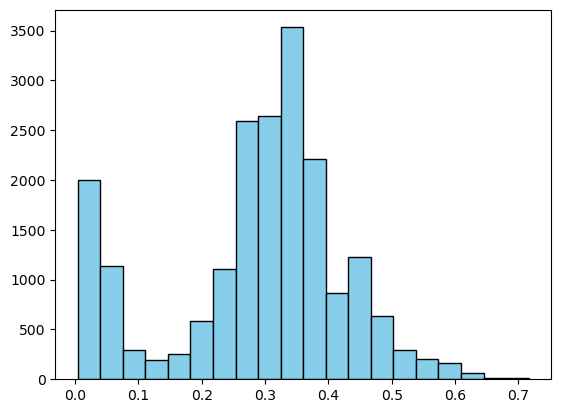

In [49]:
propensity_score = propensity_model.predict_proba(X_test_ps)[:, 1]
plt.hist(propensity_score, bins=20, color = 'skyblue', edgecolor = 'black');

In [50]:
predict_d1 = mD1.predict(X_test)
predict_d0 = mD0.predict(X_test)

In [51]:
cate = propensity_score * predict_d1 + (1 - propensity_score) * predict_d0
df_cate = pd.DataFrame({
    'cate': cate,
})
df_cate.head()

,cate
0,-0.0317
1,0.0008
2,0.0321
3,0.0259
4,-0.0240


In [52]:
df_cate['bin_cate'] = pd.qcut(df_cate['cate'], q=5, labels=False) + 1
df_cate['diabetes_%'] = y_test
df_cate.groupby('bin_cate').mean()

,cate,diabetes_%
bin_cate,,
1,-0.0664,0.0932
2,-0.0090,0.0826
3,0.0058,0.0955
4,0.0308,0.0873
5,0.1312,0.0849


In [53]:
df_cate['cate'].describe()

count   20,000.0000
mean         0.0184
std          0.0810
min         -0.7684
25%         -0.0128
50%          0.0051
75%          0.0387
max          0.8949
Name: cate, dtype: float64